# IAB딥러닝 10월 24일
> Assignment3

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김준형

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from fastai.vision.all import *

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# plt.plot 오류 발생 시 사용

# 1. 크롤링을 통한 이미지 분석 및 CAM

`(1)` 두 가지 키워드로 크롤링을 수행하여 이미지자료를 모아라. (키워드는 각자 설정)

*힌트1 : `hynn`, `iu`라는 키워드로 크롤링하여 이미지자료를 모으는 코드*

In [1]:
!pip install -Uqq duckduckgo_search

In [4]:
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastcore.all import *
def search_images(term, max_images = 200):
    return L(ddg_images(term, max_results = max_images)).itemgot('image')

In [6]:
download_images(dest = './images/train/iu', urls = search_images('iu', max_images = 200))
time.sleep(10)
download_images(dest = './images/train/hynn', urls = search_images('hynn', max_images = 200))
time.sleep(10)
download_images(dest = './images/train/iu', urls = search_images('iu kpop', max_images = 200))
time.sleep(10)
download_images(dest = './images/train/hynn', urls = search_images('hynn kpop', max_images = 200))
time.sleep(10)

In [7]:
download_images(dest = './images/test/iu', urls = search_images('iu photo', max_images = 200))
time.sleep(10)
download_images(dest = './images/test/hynn', urls = search_images('hynn photo', max_images = 200))
time.sleep(10)

*힌트2 : 불량이미지 삭제*

In [9]:
bad_images = verify_images(get_image_files('./images'))
bad_images

(#21) [Path('images/test/hynn/2743efa2-42a1-4169-ab7f-f85c7b5ca65c.jpg'),Path('images/test/hynn/495411c1-1526-4ca6-8c93-113fe1b37449.jpg'),Path('images/test/iu/06fbddd1-32b0-4a15-a92c-0bf75dc4911a.jpg'),Path('images/test/iu/23eda74b-419d-4854-af54-fe0d40f3b087.jpg'),Path('images/test/iu/47ead531-2df4-4c5c-8e4f-9e27bb84a6d2.jpg'),Path('images/test/iu/48b496d3-84d8-4d8a-bd56-19e3b1393ef6.jpg'),Path('images/test/iu/a93a4188-32a1-4729-a5d3-c95f3151687a.jpg'),Path('images/test/iu/da22bab4-8590-4278-adb5-78d6f950753e.jpg'),Path('images/train/hynn/24635948-0a5d-44d8-9066-69b68bcc3d92.png'),Path('images/train/hynn/6e3a1aaa-c5dd-4bf9-a222-e759402c4b2d.png')...]

 - 불량이미지 목록

In [10]:
bad_images.map(Path.unlink)

(#21) [None,None,None,None,None,None,None,None,None,None...]

 - 불량이미지는 dls를 불러올 때 방해되므로 제거

`(2)` ImageDataLoaders.from_folder를 이용하여 dls를 만들어라

힌트1 : dls를 만드는 코드

In [11]:
dls = ImageDataLoaders.from_folder(path = './images', train = 'train', valid = 'test', item_tfms = Resize(512), bs = 8)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


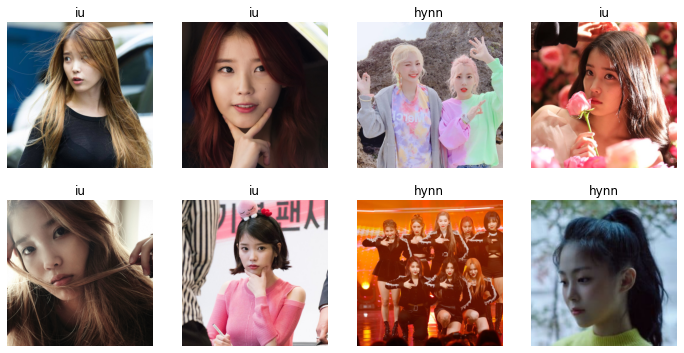

In [12]:
dls.show_batch()

`(3)` resnet34를 이용하여 학습하라

In [16]:
lrnr = vision_learner(dls, arch = resnet34, metrics = accuracy)

In [17]:
lrnr.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.808667,0.380242,0.871795,00:26


epoch,train_loss,valid_loss,accuracy,time
0,0.662695,0.412903,0.874644,00:30
1,0.321246,0.126849,0.962963,00:30
2,0.245105,0.107189,0.957265,00:30


`(4)` CAM(Class Activation Mapping)을 이용하여 (3)의 모형의 판단근거를 시각화하라

In [24]:
path = './images'

In [43]:
sftmx = torch.nn.Softmax(dim = 1)

In [33]:
net1 = lrnr.model[0]
net2 = lrnr.model[1]

In [34]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [35]:
net2 = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d(output_size = 1),
                          torch.nn.Flatten(),
                          torch.nn.Linear(512, 2, bias = False))

In [36]:
net = torch.nn.Sequential(net1, net2)

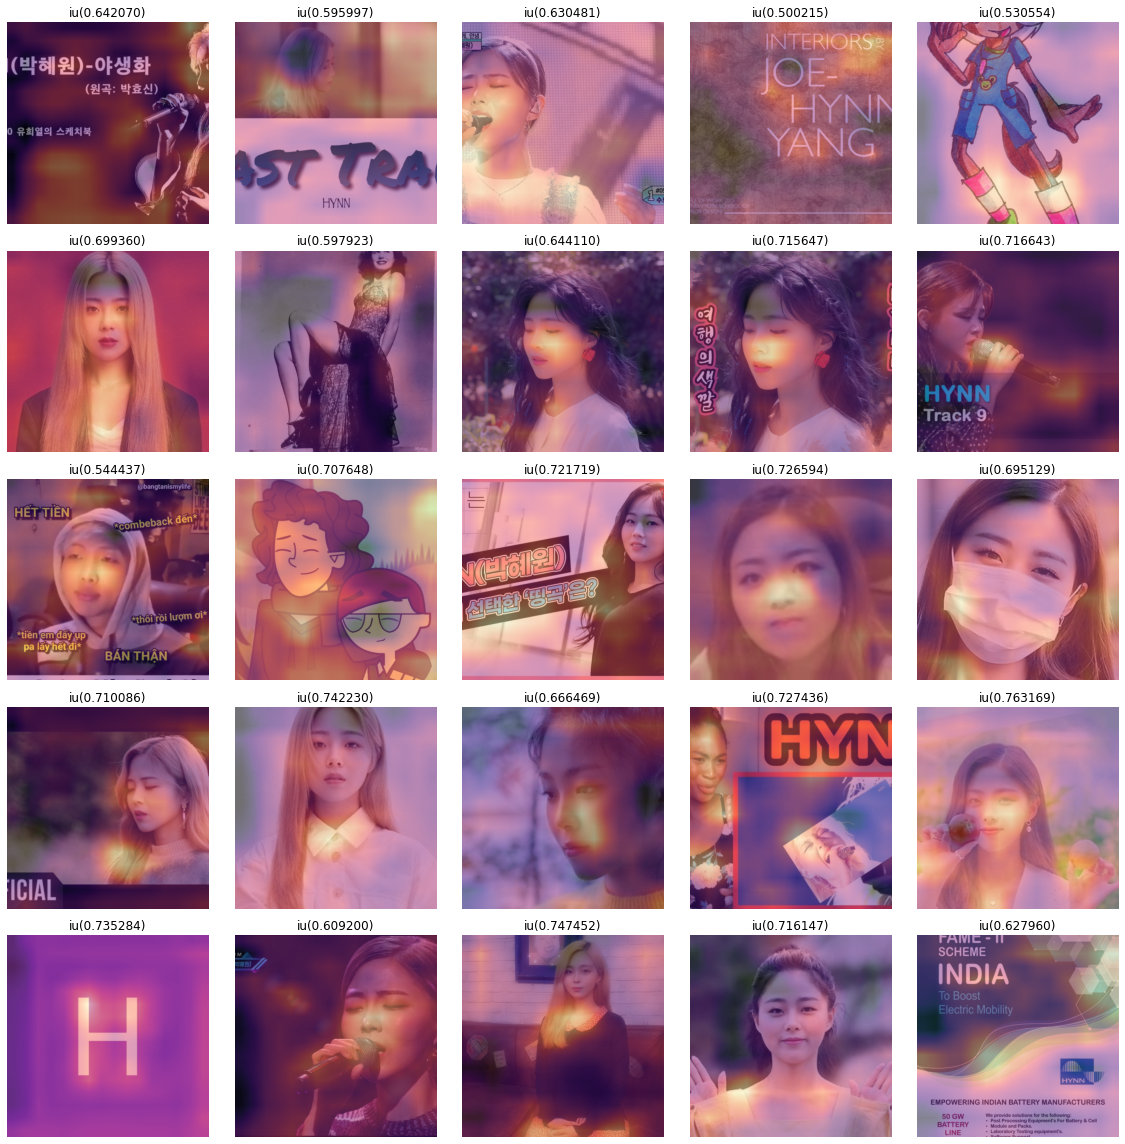

In [45]:
fig, ax = plt.subplots(5, 5)
k = 0

for i in range(5):
    for j in range(5):
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]).to('cpu'))
        why = torch.einsum('cb, abij -> acij', net2[2].weight, net1(x)).to('cpu')
        why_iu = why[0, 0, :, :]
        why_hynn = why[0, 1, :, :]
        iuprob, hynnprob = sftmx(net(x))[0][0].item(), sftmx(net(x))[0][1].item()
        if iuprob > hynnprob:
            dls.train.decode((x,))[0].squeeze().show(ax = ax[i][j])
            ax[i][j].imshow(why_iu.to('cpu').detach(), alpha = 0.5, extent = (0, 511, 511, 0), interpolation = 'bilinear', cmap = 'magma')
            ax[i][j].set_title("iu(%2f)" % iuprob)
        else:
            dls.train.decode((x,))[0].squeeze().show(ax = ax[i][j])
            ax[i][j].imshow(why_hynn.to('cpu').detach(), alpha = 0.5, extent = (0, 511, 511, 0), interpolation = 'bilinear', cmap = 'magma')
            ax[i][j].set_title("hynn(%2f)" % hynnprob)
            
        k = k + 1

fig.set_figwidth(16)
fig.set_figheight(16)
fig.tight_layout()

# 2. 다음을 읽고 참/거짓을 판단하라

`(1)` 아래의 레이어에 의하여 수행되는 변환은 선형변환이다.

```python
torch.nn.Conv2d(3,16,(5,5))
```

거짓

`-` IAB 딥러닝 수업 자료를 기반으로 공부한 내용입니다.